In [483]:
import io
import cv2
import numpy as np
import matplotlib.pyplot as plt

from collections import namedtuple
from IPython.display import clear_output
from tqdm.notebook import tqdm

from scipy.optimize import minimize
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit.circuit.library import RXGate, RYGate, RZGate, CXGate, CZGate, IGate
from qiskit_aer import AerSimulator

## Assumptions for exploration

Trial de unit-wise training and freeze parameters de trained units

#### Conditions
- Nq = 3
- Ng = 4
- dim_input = 1
- dim_output = 1

#### Gateset
- Rx
- Ry
- Rz
- Cz1
- Id

In [ ]:
nq = 3
ng = 4
dim_input = 1
dim_output = 1

## Applied gate list

To hold applied gates, some list ou dict is defined.
- Gate
- Qubit
- Parameter

In [ ]:
params = [
    Parameter("param0"),
    Parameter("param1"),
]
qubits = [
    0, 1, 2
]
gates = [
    RXGate(params[0]),
    CZGate(),
    RYGate(params[1]),
]

In [ ]:
iu_params = [
    Parameter("iuparam0"),
]
iu_qubits = [0, 1, 2]
iu_gates = [
    RXGate(iu_params[0]),
    RYGate(iu_params[0]),
    RZGate(iu_params[0]),
]

In [ ]:
qc = QuantumCircuit(nq, dim_output)

for gate, qubit in zip(iu_gates, iu_qubits):
    qc.append(gate, qargs=[qc.qubits[qubit]])

qc.barrier()

for gate, qubit in zip(gates, qubits):
    if isinstance(gate, CZGate):
        qubit = [qubit, (qubit + 1) % nq]
    if not hasattr(qubit, "__len__"):
        qubit = [qubit]
    qc.append(gate, qargs=[qc.qubits[qb] for qb in qubit])

qc.barrier()

qc.measure(0, 0)

qc.draw("mpl")

In [ ]:
f = lambda x: (x - 0.2) * (x + 0.1) * (x - 0.4)

In [ ]:
x = 0.5
y = f(x)

In [ ]:
def generate_feed_dict(x, params):
    feed_dict_iu = dict(
        iuparam0=np.atan(x),
    )
    feed_dict_train = {}
    feed_dict_train = dict(
        param0=params[0],
        param1=params[1],
    )
    feed_dict = feed_dict_iu | feed_dict_train
    return feed_dict

In [ ]:
qc.assign_parameters(generate_feed_dict(0, np.random.rand(2)))
qc.draw("mpl")

In [ ]:
sim = AerSimulator()

In [519]:
def measure_(param, shots=100):
    bc = qc.assign_parameters(generate_feed_dict(0, param))
    job = transpile(bc, sim)
    res = sim.run(job, shots=shots).result().get_counts()
    rowy = 1 * res.get("0", 0) - 1 * res.get("1", 0)
    return rowy / shots

#### Build training code

In [ ]:
GATESET = [
    (RXGate, True),
    (RYGate, True),
    (RZGate, True),
    (CZGate, False),
]

Unit = namedtuple("Unit", ["gates", "params", "qubits", "feed_func", "num_param"])

def generate_unit(num_qubit, num_gate, prefix=""):
    gates = []
    params = []
    qubits = np.random.randint(num_qubit, size=num_gate)
    num_param = 0
    
    for gate, istrainable in [GATESET[i] for i in np.random.choice(np.arange(len(GATESET)), replace=True, size=num_gate)]:
        if not istrainable:
            gates.append(gate())
            params.append(None)
            continue
        pname =  f"param_{len(params)}"
        if prefix is not None:
            pname = prefix + "_" + pname
        param = Parameter(pname)
        gates.append(gate(param))
        params.append(param)
        num_param += 1
    
    def feed_func(values):
        iter_values = iter(values)
        return {
            param.name: next(iter_values)
            for param in params if param is not None
        }
    
    return Unit(gates, params, qubits, feed_func, num_param)

In [ ]:
ENCODESET = [
    RXGate,
    RYGate,
    RZGate,
]

def generate_input_unit(num_qubit, dim_input):
    params = [
        Parameter(f"inunit_param_{i}")
        for i in range(dim_input)
    ]
    gates = [
        np.random.choice(ENCODESET)(params[0])
        for _ in range(num_qubit)
    ]
    qubits = np.arange(num_qubit)
    
    def feed_func(x):
        return dict(
            inunit_param_0=np.atan(x),
        )
    return Unit(gates, params, qubits, feed_func, 1)


def build_input_unit(num_qubit, gate_type):
    params = [Parameter("inunit_param_0")]
    gates = [gate_type(params[0]) for _ in range(num_qubit)]
    qubits = np.arange(num_qubit)
    
    def fn_feed_dict(x):
        return dict(
            inunit_param_0=np.atan(x),
        )
    return Unit(gates, params, qubits, fn_feed_dict, 1)

In [ ]:
def iterator(unit):
    return zip(unit.gates, unit.qubits)

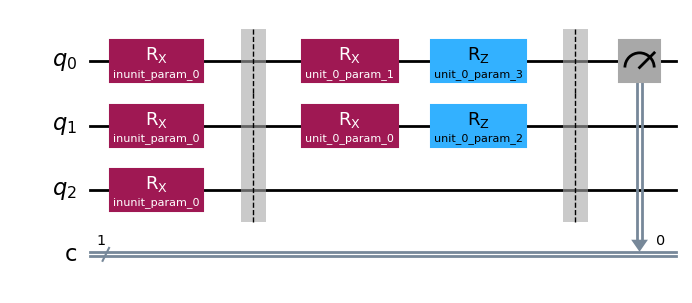

In [221]:
input_unit = build_input_unit(nq, RXGate)
units = [generate_unit(nq, ng, prefix="unit_0")]

qc = QuantumCircuit(nq, dim_output)

for gate, qubit in iterator(input_unit):
    qc.append(gate, qargs=[qc.qubits[qubit]])

qc.barrier()

for unit in units:
    for gate, qubit in iterator(unit):
        if isinstance(gate, CZGate):
            qubit = [qubit, (qubit + 1) % nq]
        else:
            qubit = [qubit]
        qc.append(gate, qargs=[qc.qubits[q] for q in qubit])
    qc.barrier()
    
qc.measure(0, 0)

qc.draw("mpl")


In [246]:
def measure_(x, units, params, shots=100):
    nparams = [unit.num_param for unit in units]
    nparams.insert(0, 0)
    param_indices = np.cumsum(nparams)
    
    params = [params[idx_de:idx_to] for idx_de, idx_to in zip(param_indices[:-1], param_indices[1:])]
    
    feed_dict = input_unit.feed_func(x)
    for unit, param in zip(units, params):
        feed_dict |= unit.feed_func(param)
    
    bc = qc.assign_parameters(feed_dict)
    job = transpile(bc, sim)
    res = sim.run(job, shots=100).result().get_counts()
    res = 1 * res.get("0", 0) - 1 * res.get("1", 0)
    return res / shots

measure(units, np.random.rand(unit.num_param))

0.62

In [224]:
inunit = build_input_unit(2, RXGate)
inunit

Unit(gates=[Instruction(name='rx', num_qubits=1, num_clbits=0, params=[Parameter(inunit_param_0)]), Instruction(name='rx', num_qubits=1, num_clbits=0, params=[Parameter(inunit_param_0)])], params=[Parameter(inunit_param_0)], qubits=array([0, 1]), feed_func=<function build_input_unit.<locals>.fn_feed_dict at 0x1113dec00>, num_param=1)

### Dev generate algo

In [225]:
Model = namedtuple("Model", ["input", "fixed", "trainable"])

In [280]:
nq = 2
ng = 3
dim_input = 1
dim_output = 1

In [281]:
def new_unit(model, nq, ng, prefix="unit_{}"):
    model.fixed.append(model.trainable.pop(0))
    model.trainable.append(
        generate_unit(nq, ng, prefix=prefix.format(len(model.fixed)))
    )
    return model

In [348]:
def new_model(nq, ng):
    return Model(
        build_input_unit(nq, RXGate),
        [],
        [generate_unit(nq, ng, prefix="unit_0")],
    )

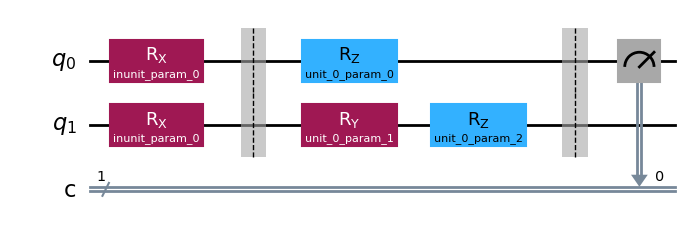

In [303]:
def generate_applied_qc(model):
    qc = QuantumCircuit(nq, dim_output)
    qr = qc.qubits
    def qargs(qubit):
        if not hasattr(qubit, "__len__"):
            return [qr[qubit]]
        return [qr[qb] for qb in qubit]
    
    for gate, qubit in iterator(model.input):
        qc.append(gate, qargs=qargs(qubit))
    qc.barrier()
    
    for unit in model.fixed:
        for gate, qubit in iterator(unit):
            if isinstance(gate, CZGate):
                qubit = [qubit, (qubit + 1) % nq]
            qc.append(gate, qargs=qargs(qubit))
        qc.barrier()
    
    unit = model.trainable[0]
    for gate, qubit in iterator(unit):
        if isinstance(gate, CZGate):
            qubit = [qubit, (qubit + 1) % nq]
        qc.append(gate, qargs=qargs(qubit))
    qc.barrier()
    
    qc.measure(0, 0)
    return qc

qc = generate_applied_qc(model)
qc.draw("mpl")

In [516]:
def build_feed_dict(x, model, fixed_params, trainable_param):
    # input
    feed_dict = model.input.feed_func(x)
    
    # fixed
    num_fparam = [unit.num_param for unit in model.fixed]
    num_fparam.insert(0, 0)
    fparam_indices = np.cumsum(num_fparam).tolist()
    for unit, idx_de, idx_to in zip(
            model.fixed, fparam_indices[:-1], fparam_indices[1:]
    ):
        feed_dict |= unit.feed_func(fixed_params[idx_de:idx_to])
    
    # trainable
    feed_dict |= model.trainable[0].feed_func(trainable_param)
    
    return feed_dict

In [530]:
def measure(x, model, fixed_params, trainable_params, shots=100):
    feed_dict = build_feed_dict(x, model, fixed_params, trainable_params)
    # print(feed_dict)
    # print("model unit-name:")
    # print(model.trainable[0])
    # return 0
    
    bc = qc.assign_parameters(feed_dict)
    job = transpile(bc, sim)
    res = sim.run(job, shots=shots).result().get_counts()
    y = 1 * res.get("0", 0) - 1 * res.get("1", 0)
    return y / shots

In [528]:
target_func = lambda x: (x - 0.7) * (x + 0.2) - 0.5

(0.0, 1.0)

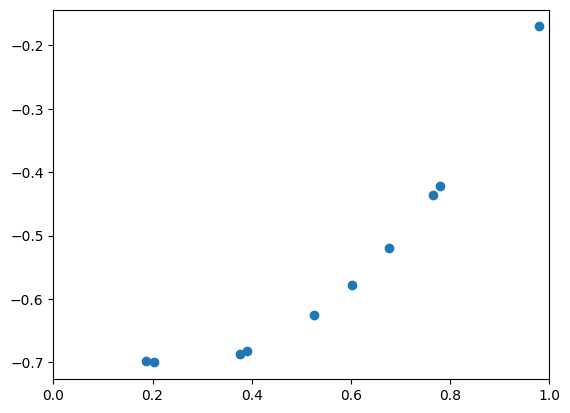

In [343]:
xtrains = np.random.rand(10)
ytrains = target_func(xtrains)
plt.scatter(xtrains, ytrains)
plt.xlim(0, 1)

In [349]:
model = new_model(nq, ng)

In [391]:
def calc_gradient(x, y, model, fixed_params, trainable_params, shots=100):
    doublepi = np.pi * 2
    demipi = np.pi / 2
    trainable_params = np.asarray(trainable_params)
    
    def shift_one_by_value(index, value):
        ret = trainable_params.copy()
        ret[index] = (trainable_params[index] + value) % doublepi
        return ret
    
    def calc_gradient_i(index, model):
        shifteds = [shift_one_by_value(index, demipi * sgn) for sgn in (1, -1)]
        predicts = [measure(
            x, model, fixed_params, shifted, shots=shots
        ) for shifted in shifteds]
        
        return (predicts[0] - predicts[1]) / 2
    
    grads = [
        calc_gradient_i(i, model)
        for i in range(len(trainable_params))
    ]
    return grads

def calc_gradients(
        xs, ys,
        model,
        fiexed_params, trainable_params,
        shots=100
):
    gradients = [
        calc_gradient(x, y, model, fiexed_params, trainable_params, shots=shots)
        for x, y in zip(xs, ys)
    ]
    mean_grads = np.mean(gradients, axis=0)
    return mean_grads


fixed = []
trainable = np.zeros(model.trainable[0].num_param)

grads = calc_gradients(
    xtrains, ytrains,
    model,
    fixed, trainable
)
trainable -= grads * 0.1
print(trainable)


[-0.0006 -0.0008  0.0434]


In [389]:
def calc_loss(xs, ys, model, fixed_params, trainable_params, shots=100):
    ps = np.asarray([
        measure(x, model, fixed_params, trainable_params, shots=shots)
        for x in xs
    ])
    loss = np.mean(np.square(ps - ys))
    return loss

calc_loss(xtrains, ytrains, model, fixed, trainable)

np.float64(2.2990874160531938)

tranable: [0.008  0.011  2.6044]
dtrainable: [ 0.      0.0006 -0.0036]


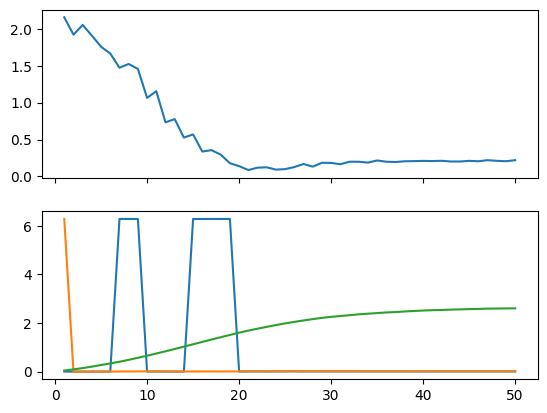

In [441]:
fixed = []
trainable = np.zeros(model.trainable[0].num_param)
print(trainable)

log_step = []
log_loss = []
log_trainables = []
for j in range(50):
    step = j + 1
    loss = calc_loss(xtrains, ytrains, model, fixed, trainable, shots=30)
    grads = calc_gradients(
        xtrains, ytrains,
        model,
        fixed, trainable,
        shots=50,
    )
    dtrainable = grads * 0.1
    trainable = (trainable - dtrainable) % (2 * np.pi)
    
    log_step.append(step)
    log_loss.append(loss)
    log_trainables.append(trainable)
    
    clear_output()
    del fig
    del axes
    
    print("tranable:", trainable)
    print("dtrainable:", dtrainable)
    fig_trainables = np.vstack(log_trainables)
    fig, axes = plt.subplots(nrows=2, sharex=True)
    axes[0].plot(log_step, log_loss, label='loss')
    for i, ft in enumerate(fig_trainables.T):
        axes[1].plot(log_step, ft, label=f'trainable_{i}')
    plt.show()

In [444]:
best_step = np.argmin(log_loss)
best_params = log_trainables[best_step]
best_params

array([0.0064, 0.0118, 1.6888])

In [415]:
def generate_objective(xs, ys, model, fixed_params, shots=100):
    def fn(params):
        loss = calc_loss(xs, ys, model, fixed_params, params, shots=shots)
        return loss
    return fn

In [416]:
obj = generate_objective(xtrains, ytrains, model, fixed, shots=100)

In [420]:
obj([np.pi,] * 3)

np.float64(0.09330051498186458)

In [425]:
from scipy.optimize import minimize

sol = minimize(
    obj,
    np.ones(model.trainable[0].num_param) * np.pi,
    # method="SLSQP",
    method="COBYLA",
    bounds=((0, 2 * np.pi), )*model.trainable[0].num_param
)

In [426]:
sol

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 0.005487895343159998
       x: [ 3.983e+00  4.464e+00  3.595e+00]
    nfev: 43
   maxcv: 0.0

In [430]:
sol.x

array([3.98347144, 4.46357141, 3.59529376])

In [476]:
xtests = np.linspace(0, 1, 101)
ytests = np.asarray([
    measure(xtest, model, fixed, sol.x, shots=300)
    for xtest in xtests
])

StopIteration: 

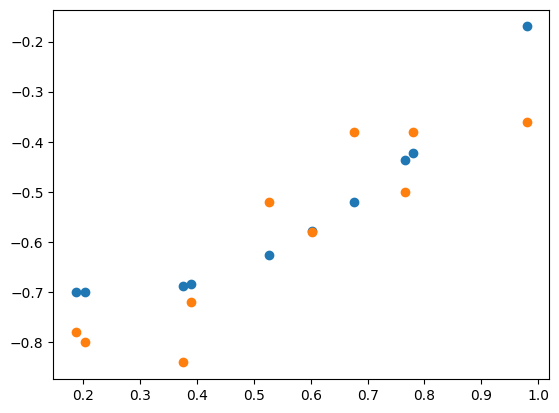

In [440]:
predicts = np.asarray([
    measure(x, model, fixed, sol.x)
    for x in xtrains
])
residuals = ytrains - predicts
# plt.scatter(xtrains, residuals)
plt.scatter(xtrains, ytrains)
plt.scatter(xtrains, predicts)

In [ ]:
plt.scatter(xtests, ytests)
plt.scatter(xtrains, ytrains)

In [384]:

grads = calc_gradients(
    xtrains, ytrains,
    model,
    fixed, trainable
)
trainable += grads * 0.1
print(trainable)

[ 0.0024  0.002  -0.124 ]


In [385]:

grads = calc_gradients(
    xtrains, ytrains,
    model,
    fixed, trainable
)
trainable += grads * 0.1
print(trainable)

[ 0.003   0.0017 -0.1566]


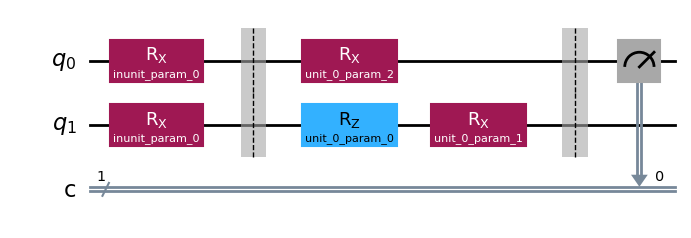

In [375]:
# model = new_unit(model, nq, ng)
qc = generate_applied_qc(model)
qc.draw("mpl")

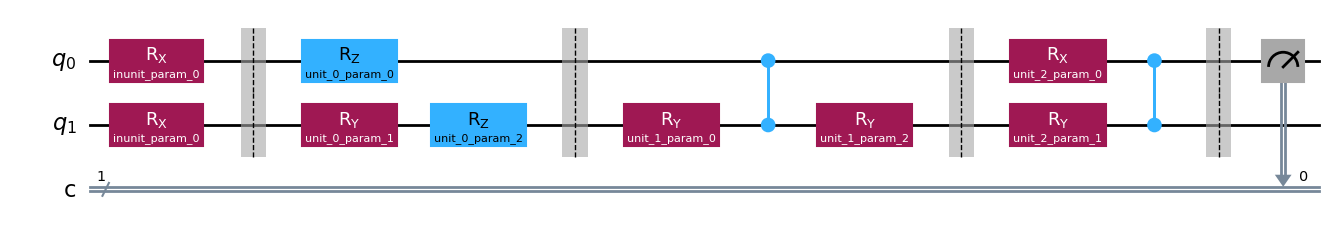

In [306]:
model = new_unit(model, nq, ng)
qc = generate_applied_qc(model)
qc.draw("mpl")

#### Random unit generation

In [445]:
nq = 2
ng = 3
dim_input = 1
dim_output = 1

In [471]:
models = [
    new_model(nq, ng)
    for _ in range(9)
]

0it [00:00, ?it/s]

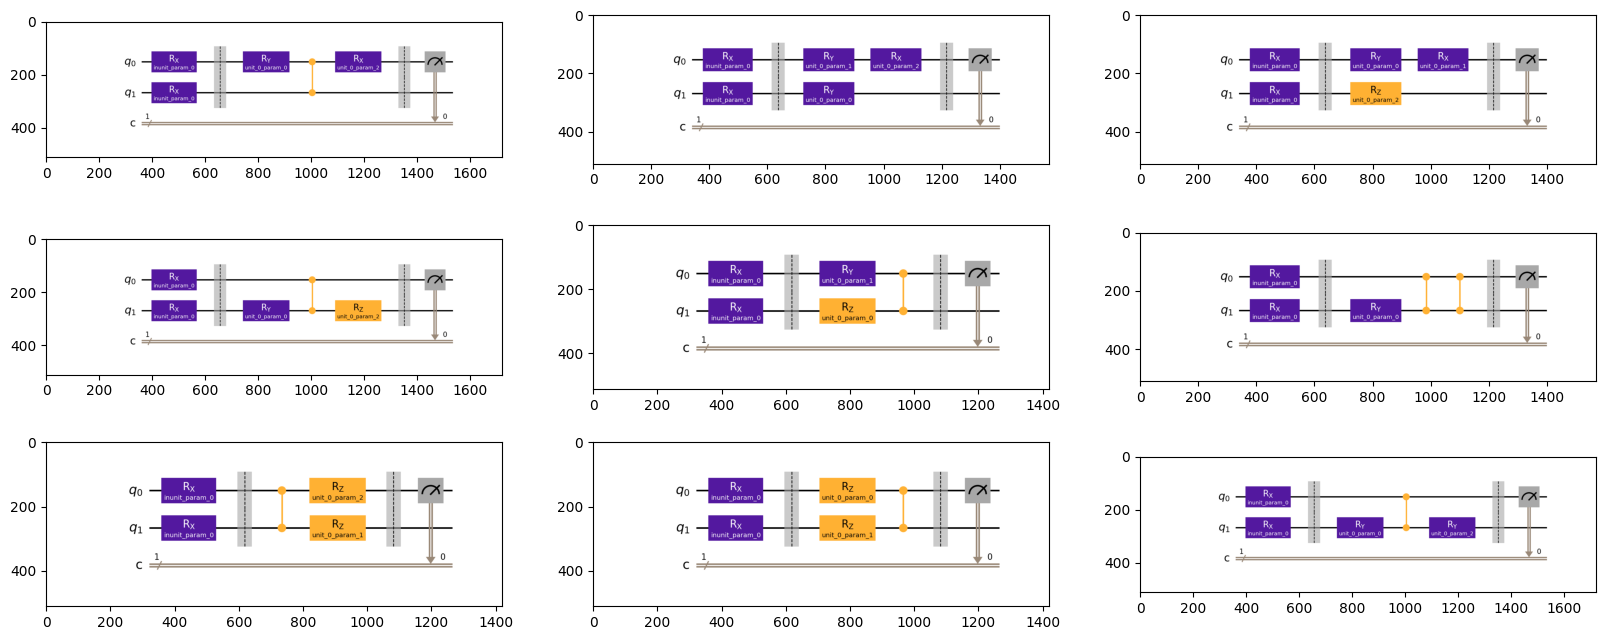

In [484]:
qcs = [
    generate_applied_qc(model)
    for model in models
]
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(20, 8))
for ax, qc in (tqdm(zip(axes.flatten(), qcs))):
    buf = io.BytesIO()
    fig_ = qc.draw("mpl")
    fig_.savefig(buf, format="png", dpi=180)
    buf.seek(0)
    img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    buf.close()
    img = cv2.imdecode(img_arr, 1)
    ax.imshow(img)
plt.show()

In [523]:
Logger = namedtuple("Logger", ["step", "loss", "grads", "trainable"])
Logger.__new__.__defaults__ = ([], [], [], [])

def store_log(logger, step, loss, grads, trainable):
    logger.step.append(step)
    logger.loss.append(loss)
    logger.grads.append(grads)
    logger.trainable.append(trainable)
    return logger

In [531]:
def train_once(xs, ys, max_iter, model, fixed_params, trainable_params, lr=1e-2, shots=30, verbose=False, visualize=False):
    
    num_digit_iter = np.ceil(np.log10(max_iter+1)).astype(int)
    if verbose:
        proot_step = "[train] step{:>" + str(num_digit_iter) + "}"
        proot_data = "loss:{:6.3f}"

    log = Logger()
    
    for step in range(1, max_iter + 1):
        if verbose:
            print(proot_step.format(step), end=" ")
        
        loss = calc_loss(xs, ys, model, fixed_params, trainable_params, shots=shots)
        # grads = calc_gradients(xs, ys, model, fixed_params, trainable_params, shots=shots)
        # trainable_params = (trainable_params - grads * lr) % (2 * np.pi)
        
        # store_log(Logger, step, loss, grads, trainable_params)
        # if verbose:
        #     print(proot_data.format(loss))
        break
        

model = new_model(2, 3)
fixed = []
trainable = np.zeros(model.trainable[0].num_param)

train_once(
    xtrains, ytrains, 10,
    model, fixed, trainable,
    verbose=True,
)

[train] step 1 

KeyError: "no parameter named 'unit_0_param_1' is present"

In [515]:
model

Model(input=Unit(gates=[Instruction(name='rx', num_qubits=1, num_clbits=0, params=[Parameter(inunit_param_0)]), Instruction(name='rx', num_qubits=1, num_clbits=0, params=[Parameter(inunit_param_0)])], params=[Parameter(inunit_param_0)], qubits=array([0, 1]), feed_func=<function build_input_unit.<locals>.fn_feed_dict at 0x116ee5080>, num_param=1), fixed=[], trainable=[Unit(gates=[Instruction(name='cz', num_qubits=2, num_clbits=0, params=[]), Instruction(name='rz', num_qubits=1, num_clbits=0, params=[Parameter(unit_0_param_1)]), Instruction(name='rz', num_qubits=1, num_clbits=0, params=[Parameter(unit_0_param_2)])], params=[None, Parameter(unit_0_param_1), Parameter(unit_0_param_2)], qubits=array([1, 1, 1]), feed_func=<function generate_unit.<locals>.feed_func at 0x116ee5da0>, num_param=2)])